https://www.kaggle.com/code/sugghi/training-3rd-place-solution/notebook
ここのソリューションをBybitで実装してみる。

変更点：
    ・　通貨ペアーは取引の多いものを選ぶ（１４まで選ぶと１分足が作れない可能性があるため減らす）

In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import time
import datetime

import pickle
import gc

from tqdm import tqdm

In [130]:
n_fold = 7
seed0 = 8586

In [131]:
# そのままコピー
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [132]:
import rbot

bb_btcusd = rbot.DummyBb()
bb_btcusd.market_type = "BTCUSD"
bb_btcusdt = rbot.DummyBb()
bb_btcusdt.market_type = "BTCUSDT"

bb_ethusd = rbot.DummyBb()
bb_ethusd.market_type = "ETHUSD"
bb_ethusdt = rbot.DummyBb()
bb_ethusdt.market_type = "ETHUSDT"

bb_xrpusdt = rbot.DummyBb()
bb_xrpusdt.market_type = "XRPUSDT"
bb_xrpusd = rbot.DummyBb()
bb_xrpusd.market_type = "XRPUSD"


In [133]:
LOAD_NEW = True
LOAD_DAYS = 10

if LOAD_NEW:
    bb_btcusd.log_load(LOAD_DAYS)
    bb_btcusd.dump()
    bb_btcusdt.log_load(LOAD_DAYS)
    bb_btcusdt.dump()
    bb_ethusd.log_load(LOAD_DAYS)
    bb_ethusd.dump()
    bb_ethusdt.log_load(LOAD_DAYS)
    bb_ethusdt.dump()
    bb_xrpusd.log_load(LOAD_DAYS)
    bb_xrpusd.dump()
    bb_xrpusdt.log_load(LOAD_DAYS)
    bb_xrpusdt.dump()
else:
    bb_btcusd.restore()
    bb_btcusdt.restore()
    bb_ethusd.restore()
    bb_ethusdt.restore()
    bb_xrpusd.restore()
    bb_xrpusdt.restore()


In [134]:
OFFSET_PERIOD = 15

def log_return(series, periods=1):
    return np.log(series).diff(periods=periods)

# Closeのログリターンを計算する（Closeでいいのかな？）
def make_df(dummy_bb, asset_id):
    df = rbot.array_to_df(dummy_bb.ohlcv(0, 0, 60))
    df['Target'] = log_return(df['close'], OFFSET_PERIOD)
    df['Asset_ID'] = asset_id
    
    return df

In [135]:
df_btcusd = make_df(bb_btcusd, 0)
df_btcusdt = make_df(bb_btcusdt, 1)
df_ethusd = make_df(bb_ethusd, 2)
df_ethusdt = make_df(bb_ethusdt, 3)
df_xrpusd = make_df(bb_xrpusd, 4)
df_xrpusdt = make_df(bb_xrpusdt, 5)

df_train = pd.concat([df_btcusd, df_btcusdt, df_ethusd, df_ethusdt, df_xrpusd, df_xrpusdt])
df_train = reduce_mem_usage(df_train)
df_train

Memory usage of dataframe is 5.25 MB
Memory usage after optimization is: 1.89 MB
Decreased by 64.1%


,open,high,low,close,volume,Target,Asset_ID
timestamp,,,,,,,
2022-06-25 00:00:00+00:00,21216.000000,21232.000000,21184.000000,21200.000000,1064828.0,NaN,0
2022-06-25 00:01:00+00:00,21200.000000,21232.000000,21184.000000,21216.000000,1366272.0,NaN,0
2022-06-25 00:02:00+00:00,21216.000000,21232.000000,21216.000000,21232.000000,624635.0,NaN,0
2022-06-25 00:03:00+00:00,21232.000000,21232.000000,21200.000000,21216.000000,1291552.0,NaN,0
2022-06-25 00:04:00+00:00,21216.000000,21216.000000,21184.000000,21184.000000,191685.0,NaN,0
...,...,...,...,...,...,...,...
2022-07-04 23:55:00+00:00,0.329102,0.329102,0.328613,0.328857,18070.0,0.001826,5
2022-07-04 23:56:00+00:00,0.328857,0.328857,0.328613,0.328857,38409.0,0.002741,5
2022-07-04 23:57:00+00:00,0.328857,0.328857,0.328857,0.328857,138658.0,0.003351,5


In [136]:
df_train = pd.concat([df_btcusd, df_btcusdt, df_ethusd, df_ethusdt, df_xrpusd, df_xrpusdt])
df_train = reduce_mem_usage(df_train)

df_train['timestamp'] = df_train.index.astype('int64')
df_train['Close'] = df_train["close"]
df_train = df_train.reset_index(drop=True)
df_train


Memory usage of dataframe is 5.25 MB
Memory usage after optimization is: 1.89 MB
Decreased by 64.1%


,open,high,low,close,volume,Target,Asset_ID,timestamp,Close
0,21216.000000,21232.000000,21184.000000,21200.000000,1064828.0,NaN,0,1656115200000000000,21200.000000
1,21200.000000,21232.000000,21184.000000,21216.000000,1366272.0,NaN,0,1656115260000000000,21216.000000
2,21216.000000,21232.000000,21216.000000,21232.000000,624635.0,NaN,0,1656115320000000000,21232.000000
3,21232.000000,21232.000000,21200.000000,21216.000000,1291552.0,NaN,0,1656115380000000000,21216.000000
4,21216.000000,21216.000000,21184.000000,21184.000000,191685.0,NaN,0,1656115440000000000,21184.000000
...,...,...,...,...,...,...,...,...,...
86084,0.329102,0.329102,0.328613,0.328857,18070.0,0.001826,5,1656978900000000000,0.328857
86085,0.328857,0.328857,0.328613,0.328857,38409.0,0.002741,5,1656978960000000000,0.328857
86086,0.328857,0.328857,0.328857,0.328857,138658.0,0.003351,5,1656979020000000000,0.328857
86087,0.328857,0.328857,0.327881,0.327881,332552.0,0.000915,5,1656979080000000000,0.327881


In [137]:
NUM_OF_ASSETS = 6

train_merged = pd.DataFrame()
train_merged[df_train.columns] = 0
for id in tqdm( range(NUM_OF_ASSETS) ):
    train_merged = train_merged.merge(df_train.loc[df_train["Asset_ID"] == id, ['timestamp', 'Close','Target']].copy(), on="timestamp", how='outer',suffixes=['', "_"+str(id)])
        
train_merged = train_merged.drop(df_train.columns.drop("timestamp"), axis=1)
train_merged = train_merged.sort_values('timestamp', ascending=True)
display(train_merged.head())


100%|██████████| 6/6 [00:00<00:00, 105.77it/s]


,timestamp,Close_0,Target_0,Close_1,Target_1,Close_2,Target_2,Close_3,Target_3,Close_4,Target_4,Close_5,Target_5
0,1656115200000000000,21200.0,NaN,21216.0,NaN,1222.0,NaN,1223.0,NaN,0.366699,NaN,0.366943,NaN
1,1656115260000000000,21216.0,NaN,21232.0,NaN,1223.0,NaN,1223.0,NaN,0.366699,NaN,0.367188,NaN
2,1656115320000000000,21232.0,NaN,21248.0,NaN,1222.0,NaN,1222.0,NaN,0.367188,NaN,0.367676,NaN
3,1656115380000000000,21216.0,NaN,21232.0,NaN,1221.0,NaN,1222.0,NaN,0.366943,NaN,0.367188,NaN
4,1656115440000000000,21184.0,NaN,21200.0,NaN,1219.0,NaN,1220.0,NaN,0.366455,NaN,0.366699,NaN


In [139]:
for id in range(NUM_OF_ASSETS):
    # print(id, train_merged[f'Close_{id}'].isnull().sum())   # Number of missing before forward fill
    train_merged[f'Close_{id}'] = train_merged[f'Close_{id}'].astype('object').fillna(method='ffill', limit=100)
    train_merged[f'Close_{id}'] = train_merged[f'Close_{id}'].astype('float64')


In [140]:
lags = [60,300,900]

def get_features(df, train=True):   
    if train == True:
        totimestamp = lambda s: np.int32(time.mktime(datetime.datetime.strptime(s, "%d/%m/%Y").timetuple()))
        valid_window = [totimestamp("12/03/2021")]
#         valid_window = [totimestamp("15/08/2021")]  #検証用
        df['train_flg'] = np.where(df['timestamp']>=valid_window[0], 0,1)

        supple_start_window = [totimestamp("22/09/2021")]

        #if use_supple_for_train:
        #    df['train_flg'] = np.where(df['timestamp']>=supple_start_window[0], 1 ,df['train_flg']  )
   
    for id in range(NUM_OF_ASSETS):    
        for lag in lags:
            df[f'log_close/mean_{lag}_id{id}'] = np.log( np.array(df[f'Close_{id}']) /  np.roll(np.append(np.convolve( np.array(df[f'Close_{id}']), np.ones(lag)/lag, mode="valid"), np.ones(lag-1)), lag-1)  )
            df[f'log_return_{lag}_id{id}']     = np.log( np.array(df[f'Close_{id}']) /  np.roll(np.array(df[f'Close_{id}']), lag)  )
    for lag in lags:
        df[f'mean_close/mean_{lag}'] =  np.mean(df.iloc[:,df.columns.str.startswith(f'log_close/mean_{lag}_id')], axis=1)
        df[f'mean_log_returns_{lag}'] = np.mean(df.iloc[:,df.columns.str.startswith(f'log_return_{lag}_id')] ,    axis=1)
        for id in range(NUM_OF_ASSETS):
            df[f'log_close/mean_{lag}-mean_close/mean_{lag}_id{id}'] = np.array( df[f'log_close/mean_{lag}_id{id}']) - np.array( df[f'mean_close/mean_{lag}']  )
            df[f'log_return_{lag}-mean_log_returns_{lag}_id{id}']    = np.array( df[f'log_return_{lag}_id{id}'])     - np.array( df[f'mean_log_returns_{lag}'] )

    if train == True:
        for id in range(NUM_OF_ASSETS):
            df = df.drop([f'Close_{id}'], axis=1)
        oldest_use_window = [totimestamp("12/01/2019")]
        df = df[  df['timestamp'] >= oldest_use_window[0]   ]

    return df

In [141]:
feat = get_features(train_merged)
feat

,timestamp,Target_0,Target_1,Target_2,Target_3,Target_4,Target_5,train_flg,log_close/mean_60_id0,log_return_60_id0,...,log_close/mean_900-mean_close/mean_900_id1,log_return_900-mean_log_returns_900_id1,log_close/mean_900-mean_close/mean_900_id2,log_return_900-mean_log_returns_900_id2,log_close/mean_900-mean_close/mean_900_id3,log_return_900-mean_log_returns_900_id3,log_close/mean_900-mean_close/mean_900_id4,log_return_900-mean_log_returns_900_id4,log_close/mean_900-mean_close/mean_900_id5,log_return_900-mean_log_returns_900_id5
0,1656115200000000000,NaN,NaN,NaN,NaN,NaN,NaN,0,9.961756,0.052685,...,4.606542,-0.031179,1.752275,0.017335,1.753093,0.017201,-6.359182,0.013923,-6.358517,0.013817
1,1656115260000000000,NaN,NaN,NaN,NaN,NaN,NaN,0,9.962511,0.054235,...,4.606797,-0.030667,1.752595,0.017912,1.752595,0.016960,-6.359681,0.012910,-6.358350,0.013469
2,1656115320000000000,NaN,NaN,NaN,NaN,NaN,NaN,0,9.963265,0.055785,...,4.607129,-0.030653,1.751355,0.017307,1.751355,0.016355,-6.358772,0.013501,-6.357443,0.014059
3,1656115380000000000,NaN,NaN,NaN,NaN,NaN,NaN,0,9.962511,0.053439,...,4.607096,-0.030527,1.751256,0.017367,1.752075,0.016281,-6.358717,0.013715,-6.358052,0.013609
4,1656115440000000000,NaN,NaN,NaN,NaN,NaN,NaN,0,9.961001,0.052725,...,4.607080,-0.030543,1.751110,0.017221,1.751930,0.016136,-6.358556,0.013876,-6.357890,0.013771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14393,1656978900000000000,-0.002125,-0.001974,-0.000217,-0.000043,0.001525,0.001826,0,0.001056,0.001585,...,-0.002207,-0.005718,0.011828,0.030869,0.011532,0.029835,-0.009873,-0.024604,-0.008535,-0.023917
14394,1656978960000000000,-0.001731,-0.001630,0.000261,0.000347,0.001831,0.002741,0,0.001030,0.001585,...,-0.002735,-0.006112,0.012050,0.030431,0.011754,0.030347,-0.010333,-0.025787,-0.008254,-0.022813
14395,1656979020000000000,-0.000692,-0.000494,0.000783,0.000347,0.003048,0.003351,0,0.000990,0.002378,...,-0.002152,-0.005663,0.010935,0.029219,0.010640,0.029136,-0.008290,-0.023126,-0.008443,-0.023156
14396,1656979080000000000,-0.001362,-0.001385,-0.000653,-0.000435,0.001527,0.000915,0,-0.000634,0.002382,...,-0.001630,-0.005177,0.011260,0.030500,0.010968,0.029466,-0.009141,-0.024033,-0.009290,-0.024832


In [142]:
# define features for LGBM
not_use_features_train = ['timestamp', 'train_flg']
for id in range(NUM_OF_ASSETS):
    not_use_features_train.append(f'Target_{id}')

features = feat.columns 
features = features.drop(not_use_features_train)
features = list(features)
# display(features)  
len(features)

78

In [143]:
#del train_merged
#del df_train
gc.collect()

633

In [144]:
# define the evaluation metric
def correlation(a, train_data):
    
    b = train_data.get_label()
    
    a = np.ravel(a)
    b = np.ravel(b)

    len_data = len(a)
    mean_a = np.sum(a) / len_data
    mean_b = np.sum(b) / len_data
    var_a = np.sum(np.square(a - mean_a)) / len_data
    var_b = np.sum(np.square(b - mean_b)) / len_data

    cov = np.sum((a * b))/len_data - mean_a*mean_b
    corr = cov / np.sqrt(var_a * var_b)

    return 'corr', corr, True

# For CV score calculation
def corr_score(pred, valid):
    len_data = len(pred)
    mean_pred = np.sum(pred) / len_data
    mean_valid = np.sum(valid) / len_data
    var_pred = np.sum(np.square(pred - mean_pred)) / len_data
    var_valid = np.sum(np.square(valid - mean_valid)) / len_data

    cov = np.sum((pred * valid))/len_data - mean_pred*mean_valid
    corr = cov / np.sqrt(var_pred * var_valid)

    return corr

# For CV score calculation
def wcorr_score(pred, valid, weight):
    len_data = len(pred)
    sum_w = np.sum(weight)
    mean_pred = np.sum(pred * weight) / sum_w
    mean_valid = np.sum(valid * weight) / sum_w
    var_pred = np.sum(weight * np.square(pred - mean_pred)) / sum_w
    var_valid = np.sum(weight * np.square(valid - mean_valid)) / sum_w

    cov = np.sum((pred * valid * weight)) / sum_w - mean_pred*mean_valid
    corr = cov / np.sqrt(var_pred * var_valid)

    return corr

In [145]:
# from: https://blog.amedama.jp/entry/lightgbm-cv-feature-importance
# (used in nyanp's Optiver solution)
def plot_importance(importances, features_names = features, PLOT_TOP_N = 20, figsize=(10, 10)):
    importance_df = pd.DataFrame(data=importances, columns=features)
    sorted_indices = importance_df.median(axis=0).sort_values(ascending=False).index
    sorted_importance_df = importance_df.loc[:, sorted_indices]
    plot_cols = sorted_importance_df.columns[:PLOT_TOP_N]
    _, ax = plt.subplots(figsize=figsize)
    ax.grid()
    ax.set_xscale('log')
    ax.set_ylabel('Feature')
    ax.set_xlabel('Importance')
    sns.boxplot(data=sorted_importance_df[plot_cols],
                orient='h',
                ax=ax)
    plt.show()

In [146]:
# from: https://www.kaggle.com/code/nrcjea001/lgbm-embargocv-weightedpearson-lagtarget/
def get_time_series_cross_val_splits(data, cv = n_fold, embargo = 3750):
    all_train_timestamps = data['timestamp'].unique()
    len_split = len(all_train_timestamps) // cv
    test_splits = [all_train_timestamps[i * len_split:(i + 1) * len_split] for i in range(cv)]
    # fix the last test split to have all the last timestamps, in case the number of timestamps wasn't divisible by cv
    rem = len(all_train_timestamps) - len_split*cv
    if rem>0:
        test_splits[-1] = np.append(test_splits[-1], all_train_timestamps[-rem:])

    train_splits = []
    for test_split in test_splits:
        test_split_max = int(np.max(test_split))
        test_split_min = int(np.min(test_split))
        # get all of the timestamps that aren't in the test split
        train_split_not_embargoed = [e for e in all_train_timestamps if not (test_split_min <= int(e) <= test_split_max)]
        # embargo the train split so we have no leakage. Note timestamps are expressed in seconds, so multiply by 60
        embargo_sec = 60*embargo
        train_split = [e for e in train_split_not_embargoed if
                       abs(int(e) - test_split_max) > embargo_sec and abs(int(e) - test_split_min) > embargo_sec]
        train_splits.append(train_split)

    # convenient way to iterate over train and test splits
    train_test_zip = zip(train_splits, test_splits)
    return train_test_zip

In [153]:
def get_Xy_and_model_for_asset(df_proc, asset_id):
    df_proc = df_proc.loc[  (df_proc[f'Target_{asset_id}'] == df_proc[f'Target_{asset_id}'])  ]
    #if not_use_overlap_to_train:
    #   df_proc = df_proc.loc[  (df_proc['train_flg'] == 1)  ]
    
# EmbargoCV
    train_test_zip = get_time_series_cross_val_splits(df_proc, cv = n_fold, embargo = 3750)
    print("entering time series cross validation loop")
    importances = []
    oof_pred = []
    oof_valid = []
    
    for split, train_test_split in enumerate(train_test_zip):
        gc.collect()
        
        print(f"doing split {split+1} out of {n_fold}")
        train_split, test_split = train_test_split
        train_split_index = df_proc['timestamp'].isin(train_split)
        test_split_index = df_proc['timestamp'].isin(test_split)
    
        train_dataset = lgb.Dataset(df_proc.loc[train_split_index, features],
                                    df_proc.loc[train_split_index, f'Target_{asset_id}'].values, 
                                    feature_name = features, 
                                   )
        val_dataset = lgb.Dataset(df_proc.loc[test_split_index, features], 
                                  df_proc.loc[test_split_index, f'Target_{asset_id}'].values, 
                                  feature_name = features, 
                                 )

        print(f"number of train data: {len(df_proc.loc[train_split_index])}")
        print(f"number of val data:   {len(df_proc.loc[test_split_index])}")

        model = lgb.train(params = params,
                          train_set = train_dataset, 
                          valid_sets=[train_dataset, val_dataset],
                          valid_names=['tr', 'vl'],
                          num_boost_round = 5000,
                          verbose_eval = 100,     
                          feval = correlation,
                         )
        importances.append(model.feature_importance(importance_type='gain'))
        
        file = f'trained_model_id{asset_id}_fold{split}.pkl'
        pickle.dump(model, open(file, 'wb'))
        print(f"Trained model was saved to 'trained_model_id{asset_id}_fold{split}.pkl'")
        print("")
            
        oof_pred += list(  model.predict(df_proc.loc[test_split_index, features])        )
        oof_valid += list(   df_proc.loc[test_split_index, f'Target_{asset_id}'].values    )
    
    
    plot_importance(np.array(importances),features, PLOT_TOP_N = 20, figsize=(10, 5))

    return oof_pred, oof_valid

In [154]:
# Weigthの計算が不明

df_asset_details = pd.DataFrame(data={
    'Asset_ID': [0, 1, 2, 3, 4, 5], 
    'Weight': [1, 1, 1, 1, 1, 1],
    "Asset_Name": ['BTCUSD', 'BTCUSDT', 'ETHUSD', 'ETHUSDT', 'XRPUSD', 'XRPUSDT'],
    })
df_asset_details

,Asset_ID,Weight,Asset_Name
0,0,1,BTCUSD
1,1,1,BTCUSDT
2,2,1,ETHUSD
3,3,1,ETHUSDT
4,4,1,XRPUSD
5,5,1,XRPUSDT


In [156]:
params = {
    'early_stopping_rounds': 50,
    'objective': 'regression',
    'metric': 'rmse',
#     'metric': 'None',
    'boosting_type': 'gbdt',
    'max_depth': 5,
    'verbose': -1,
    'max_bin':600,
    'min_data_in_leaf':50,
    'learning_rate': 0.03,
    'subsample': 0.7,
    'subsample_freq': 1,
    'feature_fraction': 1,
    'lambda_l1': 0.5,
    'lambda_l2': 2,
    'seed':seed0,
    'feature_fraction_seed': seed0,
    'bagging_fraction_seed': seed0,
    'drop_seed': seed0,
    'data_random_seed': seed0,
    'extra_trees': True,
    'extra_seed': seed0,
    'zero_as_missing': True,
    "first_metric_only": True
    }

Training model for BTCUSD           (ID=0 )
entering time series cross validation loop
doing split 1 out of 7
number of train data: 12329
number of val data:   2054
Training until validation scores don't improve for 50 rounds


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	tr's rmse: 0.00281239	tr's corr: 0.680183	vl's rmse: 0.00182869	vl's corr: 0.686569
Early stopping, best iteration is:
[76]	tr's rmse: 0.00287112	tr's corr: 0.671153	vl's rmse: 0.00182054	vl's corr: 0.692431
Evaluated only: rmse
Trained model was saved to 'trained_model_id0_fold0.pkl'

doing split 2 out of 7
number of train data: 12329
number of val data:   2054
Training until validation scores don't improve for 50 rounds


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	tr's rmse: 0.00279364	tr's corr: 0.667139	vl's rmse: 0.00221018	vl's corr: 0.723957
[200]	tr's rmse: 0.00268139	tr's corr: 0.692421	vl's rmse: 0.00212983	vl's corr: 0.7402
[300]	tr's rmse: 0.00263566	tr's corr: 0.704327	vl's rmse: 0.00209989	vl's corr: 0.747993
[400]	tr's rmse: 0.00261094	tr's corr: 0.710175	vl's rmse: 0.0020891	vl's corr: 0.750244
[500]	tr's rmse: 0.00259761	tr's corr: 0.713549	vl's rmse: 0.00208216	vl's corr: 0.751948
[600]	tr's rmse: 0.00258833	tr's corr: 0.715839	vl's rmse: 0.00207856	vl's corr: 0.752744
[700]	tr's rmse: 0.00258057	tr's corr: 0.717666	vl's rmse: 0.00207496	vl's corr: 0.753556
[800]	tr's rmse: 0.00257581	tr's corr: 0.718797	vl's rmse: 0.00207286	vl's corr: 0.754067
[900]	tr's rmse: 0.00257016	tr's corr: 0.720475	vl's rmse: 0.00206995	vl's corr: 0.754838
[1000]	tr's rmse: 0.00256453	tr's corr: 0.721854	vl's rmse: 0.00206715	vl's corr: 0.755526
[1100]	tr's rmse: 0.00256051	tr's corr: 0.722671	vl's rmse: 0.0020656	vl's corr: 0.75586
[1200]	tr's r

/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	tr's rmse: 0.00282486	tr's corr: 0.672609	vl's rmse: 0.00179952	vl's corr: 0.74972
[200]	tr's rmse: 0.00270097	tr's corr: 0.700577	vl's rmse: 0.00175188	vl's corr: 0.758934
[300]	tr's rmse: 0.00265697	tr's corr: 0.711021	vl's rmse: 0.00173226	vl's corr: 0.764398
[400]	tr's rmse: 0.00263402	tr's corr: 0.716155	vl's rmse: 0.00172193	vl's corr: 0.767193
[500]	tr's rmse: 0.0026216	tr's corr: 0.718982	vl's rmse: 0.00171738	vl's corr: 0.768405
[600]	tr's rmse: 0.00261235	tr's corr: 0.721034	vl's rmse: 0.00171467	vl's corr: 0.769066
[700]	tr's rmse: 0.00260538	tr's corr: 0.722784	vl's rmse: 0.00171256	vl's corr: 0.76973
[800]	tr's rmse: 0.00259935	tr's corr: 0.724163	vl's rmse: 0.00171139	vl's corr: 0.770096
[900]	tr's rmse: 0.00259478	tr's corr: 0.725335	vl's rmse: 0.00170982	vl's corr: 0.770547
[1000]	tr's rmse: 0.00259009	tr's corr: 0.726369	vl's rmse: 0.00170873	vl's corr: 0.770805
[1100]	tr's rmse: 0.0025861	tr's corr: 0.727348	vl's rmse: 0.00170801	vl's corr: 0.770976
[1200]	tr's 

/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	tr's rmse: 0.00273867	tr's corr: 0.665759	vl's rmse: 0.00267192	vl's corr: 0.688088
[200]	tr's rmse: 0.00263126	tr's corr: 0.69055	vl's rmse: 0.00258416	vl's corr: 0.705473
[300]	tr's rmse: 0.00258791	tr's corr: 0.702026	vl's rmse: 0.00254668	vl's corr: 0.714512
[400]	tr's rmse: 0.00256478	tr's corr: 0.707865	vl's rmse: 0.00253149	vl's corr: 0.718012
[500]	tr's rmse: 0.00255092	tr's corr: 0.711507	vl's rmse: 0.00252079	vl's corr: 0.720588
[600]	tr's rmse: 0.00253865	tr's corr: 0.714946	vl's rmse: 0.00251424	vl's corr: 0.722179
[700]	tr's rmse: 0.00253069	tr's corr: 0.717074	vl's rmse: 0.00250702	vl's corr: 0.723991
[800]	tr's rmse: 0.00252652	tr's corr: 0.717983	vl's rmse: 0.00250417	vl's corr: 0.724609
[900]	tr's rmse: 0.00252204	tr's corr: 0.7192	vl's rmse: 0.00250143	vl's corr: 0.725252
[1000]	tr's rmse: 0.00251651	tr's corr: 0.72036	vl's rmse: 0.0024994	vl's corr: 0.725565
[1100]	tr's rmse: 0.00251286	tr's corr: 0.721274	vl's rmse: 0.00249762	vl's corr: 0.725943
[1200]	tr's r

/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	tr's rmse: 0.00216241	tr's corr: 0.697277	vl's rmse: 0.00530574	vl's corr: 0.571261
[200]	tr's rmse: 0.00209695	tr's corr: 0.711732	vl's rmse: 0.00520835	vl's corr: 0.583135
[300]	tr's rmse: 0.00207224	tr's corr: 0.719219	vl's rmse: 0.00517678	vl's corr: 0.588901
[400]	tr's rmse: 0.00206193	tr's corr: 0.721864	vl's rmse: 0.00516142	vl's corr: 0.591373
[500]	tr's rmse: 0.00205471	tr's corr: 0.72414	vl's rmse: 0.00515053	vl's corr: 0.593779
[600]	tr's rmse: 0.00204938	tr's corr: 0.725553	vl's rmse: 0.00514327	vl's corr: 0.594958
[700]	tr's rmse: 0.00204486	tr's corr: 0.72702	vl's rmse: 0.00513692	vl's corr: 0.596205
[800]	tr's rmse: 0.0020423	tr's corr: 0.727756	vl's rmse: 0.00513273	vl's corr: 0.596974
[900]	tr's rmse: 0.00203963	tr's corr: 0.728556	vl's rmse: 0.00512908	vl's corr: 0.597641
[1000]	tr's rmse: 0.00203782	tr's corr: 0.729085	vl's rmse: 0.00512634	vl's corr: 0.598156
[1100]	tr's rmse: 0.00203537	tr's corr: 0.729653	vl's rmse: 0.00512133	vl's corr: 0.599039
[1200]	tr's

/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	tr's rmse: 0.00282432	tr's corr: 0.678405	vl's rmse: 0.00179482	vl's corr: 0.715546
[200]	tr's rmse: 0.00270277	tr's corr: 0.70439	vl's rmse: 0.0017443	vl's corr: 0.727645
[300]	tr's rmse: 0.00265929	tr's corr: 0.714906	vl's rmse: 0.00172523	vl's corr: 0.735201
[400]	tr's rmse: 0.00263358	tr's corr: 0.720626	vl's rmse: 0.00171604	vl's corr: 0.738033
[500]	tr's rmse: 0.00262073	tr's corr: 0.723815	vl's rmse: 0.00171268	vl's corr: 0.739824
[600]	tr's rmse: 0.00261468	tr's corr: 0.725182	vl's rmse: 0.00171005	vl's corr: 0.740496
[700]	tr's rmse: 0.00260804	tr's corr: 0.726762	vl's rmse: 0.00170871	vl's corr: 0.740911
[800]	tr's rmse: 0.00260024	tr's corr: 0.728652	vl's rmse: 0.00170759	vl's corr: 0.741587
[900]	tr's rmse: 0.0025961	tr's corr: 0.729756	vl's rmse: 0.00170699	vl's corr: 0.742304
[1000]	tr's rmse: 0.00259036	tr's corr: 0.730908	vl's rmse: 0.0017056	vl's corr: 0.742463
[1100]	tr's rmse: 0.00258654	tr's corr: 0.731676	vl's rmse: 0.00170459	vl's corr: 0.74262
Early stoppin

/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	tr's rmse: 0.00278633	tr's corr: 0.671044	vl's rmse: 0.0022369	vl's corr: 0.683768
[200]	tr's rmse: 0.00267299	tr's corr: 0.696556	vl's rmse: 0.00217449	vl's corr: 0.699345
[300]	tr's rmse: 0.00263136	tr's corr: 0.707084	vl's rmse: 0.00214921	vl's corr: 0.707176
[400]	tr's rmse: 0.00261041	tr's corr: 0.71203	vl's rmse: 0.00213596	vl's corr: 0.711481
[500]	tr's rmse: 0.0025971	tr's corr: 0.71533	vl's rmse: 0.00212747	vl's corr: 0.714235
[600]	tr's rmse: 0.00259016	tr's corr: 0.71707	vl's rmse: 0.00212353	vl's corr: 0.715461
[700]	tr's rmse: 0.00258489	tr's corr: 0.718123	vl's rmse: 0.00212146	vl's corr: 0.716182
[800]	tr's rmse: 0.00257684	tr's corr: 0.720369	vl's rmse: 0.00211636	vl's corr: 0.717795
[900]	tr's rmse: 0.00257415	tr's corr: 0.720998	vl's rmse: 0.00211458	vl's corr: 0.718342
[1000]	tr's rmse: 0.00256852	tr's corr: 0.722184	vl's rmse: 0.00211207	vl's corr: 0.719217
[1100]	tr's rmse: 0.00256412	tr's corr: 0.723163	vl's rmse: 0.00211128	vl's corr: 0.719554
[1200]	tr's r

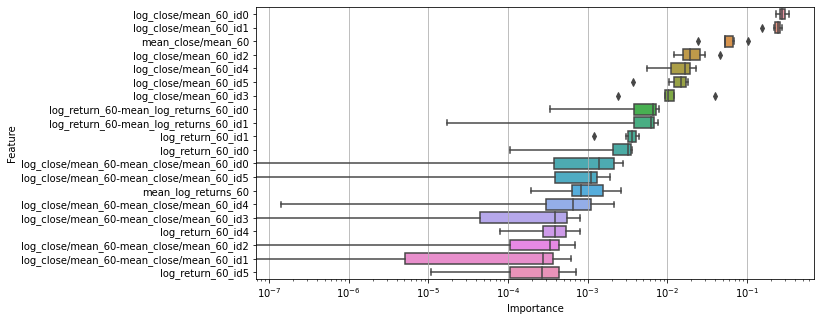

OOF corr score of BTCUSD (ID=0) is 0.67479. (Weight: 1.00000)


Training model for BTCUSDT          (ID=1 )
entering time series cross validation loop
doing split 1 out of 7
number of train data: 12330
number of val data:   2055
Training until validation scores don't improve for 50 rounds


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	tr's rmse: 0.00278294	tr's corr: 0.681113	vl's rmse: 0.00178341	vl's corr: 0.690331
Early stopping, best iteration is:
[91]	tr's rmse: 0.00280316	tr's corr: 0.677202	vl's rmse: 0.00177764	vl's corr: 0.692936
Evaluated only: rmse
Trained model was saved to 'trained_model_id1_fold0.pkl'

doing split 2 out of 7
number of train data: 12330
number of val data:   2055
Training until validation scores don't improve for 50 rounds


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	tr's rmse: 0.0027522	tr's corr: 0.670985	vl's rmse: 0.00217371	vl's corr: 0.727749
[200]	tr's rmse: 0.00264707	tr's corr: 0.693425	vl's rmse: 0.002114	vl's corr: 0.738053
[300]	tr's rmse: 0.0026042	tr's corr: 0.704393	vl's rmse: 0.00208978	vl's corr: 0.744233
[400]	tr's rmse: 0.00258118	tr's corr: 0.710038	vl's rmse: 0.00207892	vl's corr: 0.746875
[500]	tr's rmse: 0.00257015	tr's corr: 0.712555	vl's rmse: 0.00207279	vl's corr: 0.748291
[600]	tr's rmse: 0.00256043	tr's corr: 0.715164	vl's rmse: 0.00206786	vl's corr: 0.749524
[700]	tr's rmse: 0.00255303	tr's corr: 0.716966	vl's rmse: 0.00206423	vl's corr: 0.750452
[800]	tr's rmse: 0.00254793	tr's corr: 0.718171	vl's rmse: 0.00206194	vl's corr: 0.751003
[900]	tr's rmse: 0.00254386	tr's corr: 0.719226	vl's rmse: 0.00205963	vl's corr: 0.751598
[1000]	tr's rmse: 0.00253868	tr's corr: 0.720505	vl's rmse: 0.00205852	vl's corr: 0.751875
[1100]	tr's rmse: 0.00253673	tr's corr: 0.720849	vl's rmse: 0.00205726	vl's corr: 0.752173
[1200]	tr's 

/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	tr's rmse: 0.00278406	tr's corr: 0.675717	vl's rmse: 0.00177843	vl's corr: 0.751751
[200]	tr's rmse: 0.00267365	tr's corr: 0.699069	vl's rmse: 0.00173038	vl's corr: 0.760316
[300]	tr's rmse: 0.00263565	tr's corr: 0.708075	vl's rmse: 0.00171112	vl's corr: 0.765627
[400]	tr's rmse: 0.00260699	tr's corr: 0.715046	vl's rmse: 0.00170184	vl's corr: 0.768107
[500]	tr's rmse: 0.00259171	tr's corr: 0.718896	vl's rmse: 0.00169653	vl's corr: 0.769726
[600]	tr's rmse: 0.00258338	tr's corr: 0.720607	vl's rmse: 0.00169313	vl's corr: 0.770644
[700]	tr's rmse: 0.00257606	tr's corr: 0.722514	vl's rmse: 0.00169104	vl's corr: 0.771275
[800]	tr's rmse: 0.0025708	tr's corr: 0.723867	vl's rmse: 0.00168908	vl's corr: 0.771851
[900]	tr's rmse: 0.00256715	tr's corr: 0.72469	vl's rmse: 0.00168824	vl's corr: 0.772041
Early stopping, best iteration is:
[912]	tr's rmse: 0.0025664	tr's corr: 0.724851	vl's rmse: 0.00168804	vl's corr: 0.772091
Evaluated only: rmse
Trained model was saved to 'trained_model_id1_f

/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	tr's rmse: 0.0026931	tr's corr: 0.673467	vl's rmse: 0.00262615	vl's corr: 0.686596
[200]	tr's rmse: 0.00260006	tr's corr: 0.692316	vl's rmse: 0.00255546	vl's corr: 0.698982
[300]	tr's rmse: 0.00256276	tr's corr: 0.701909	vl's rmse: 0.0025293	vl's corr: 0.70519
[400]	tr's rmse: 0.00253617	tr's corr: 0.708636	vl's rmse: 0.00251477	vl's corr: 0.708454
[500]	tr's rmse: 0.00252343	tr's corr: 0.712074	vl's rmse: 0.00250513	vl's corr: 0.710889
[600]	tr's rmse: 0.0025131	tr's corr: 0.714685	vl's rmse: 0.00249924	vl's corr: 0.712308
[700]	tr's rmse: 0.00250505	tr's corr: 0.716858	vl's rmse: 0.00249413	vl's corr: 0.71364
[800]	tr's rmse: 0.00250096	tr's corr: 0.717829	vl's rmse: 0.00249217	vl's corr: 0.714105
[900]	tr's rmse: 0.00249841	tr's corr: 0.718493	vl's rmse: 0.00248964	vl's corr: 0.71472
[1000]	tr's rmse: 0.00249478	tr's corr: 0.719214	vl's rmse: 0.00248782	vl's corr: 0.715136
[1100]	tr's rmse: 0.00249178	tr's corr: 0.719873	vl's rmse: 0.00248601	vl's corr: 0.715555
[1200]	tr's rm

/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	tr's rmse: 0.00214398	tr's corr: 0.693154	vl's rmse: 0.00528352	vl's corr: 0.567697
[200]	tr's rmse: 0.0020743	tr's corr: 0.709192	vl's rmse: 0.00517355	vl's corr: 0.583213
[300]	tr's rmse: 0.00205019	tr's corr: 0.716543	vl's rmse: 0.00514177	vl's corr: 0.588725
[400]	tr's rmse: 0.00203588	tr's corr: 0.720741	vl's rmse: 0.00511959	vl's corr: 0.592971
[500]	tr's rmse: 0.00202965	tr's corr: 0.722715	vl's rmse: 0.00511091	vl's corr: 0.59466
[600]	tr's rmse: 0.00202636	tr's corr: 0.723493	vl's rmse: 0.00510563	vl's corr: 0.595367
[700]	tr's rmse: 0.00202119	tr's corr: 0.725138	vl's rmse: 0.00509668	vl's corr: 0.597243
[800]	tr's rmse: 0.00201692	tr's corr: 0.72656	vl's rmse: 0.00509038	vl's corr: 0.598719
[900]	tr's rmse: 0.00201577	tr's corr: 0.726874	vl's rmse: 0.00508897	vl's corr: 0.5989
[1000]	tr's rmse: 0.00201419	tr's corr: 0.727304	vl's rmse: 0.0050868	vl's corr: 0.599274
[1100]	tr's rmse: 0.00201199	tr's corr: 0.72799	vl's rmse: 0.0050837	vl's corr: 0.599776
[1200]	tr's rmse

/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	tr's rmse: 0.00278662	tr's corr: 0.681174	vl's rmse: 0.00174465	vl's corr: 0.718578
[200]	tr's rmse: 0.00267377	tr's corr: 0.704988	vl's rmse: 0.00169822	vl's corr: 0.728878
[300]	tr's rmse: 0.00263324	tr's corr: 0.714592	vl's rmse: 0.00168189	vl's corr: 0.734733
[400]	tr's rmse: 0.00261106	tr's corr: 0.719507	vl's rmse: 0.00167359	vl's corr: 0.736886
[500]	tr's rmse: 0.00259592	tr's corr: 0.723166	vl's rmse: 0.00167057	vl's corr: 0.737938
[600]	tr's rmse: 0.00258619	tr's corr: 0.725536	vl's rmse: 0.00166812	vl's corr: 0.739157
[700]	tr's rmse: 0.00258084	tr's corr: 0.726779	vl's rmse: 0.00166687	vl's corr: 0.739549
[800]	tr's rmse: 0.00257398	tr's corr: 0.728498	vl's rmse: 0.00166595	vl's corr: 0.739792
[900]	tr's rmse: 0.00257182	tr's corr: 0.72894	vl's rmse: 0.00166524	vl's corr: 0.739877
[1000]	tr's rmse: 0.00256674	tr's corr: 0.730089	vl's rmse: 0.00166362	vl's corr: 0.740594
[1100]	tr's rmse: 0.00256311	tr's corr: 0.730797	vl's rmse: 0.00166202	vl's corr: 0.740822
[1200]	tr

/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	tr's rmse: 0.00275787	tr's corr: 0.669796	vl's rmse: 0.0022541	vl's corr: 0.675635
[200]	tr's rmse: 0.00264297	tr's corr: 0.695824	vl's rmse: 0.00216659	vl's corr: 0.699005
[300]	tr's rmse: 0.00260205	tr's corr: 0.706107	vl's rmse: 0.00213788	vl's corr: 0.707828
[400]	tr's rmse: 0.0025822	tr's corr: 0.710926	vl's rmse: 0.00212772	vl's corr: 0.71103
[500]	tr's rmse: 0.00257056	tr's corr: 0.713789	vl's rmse: 0.00212207	vl's corr: 0.712854
[600]	tr's rmse: 0.00256314	tr's corr: 0.715557	vl's rmse: 0.00211677	vl's corr: 0.714533
[700]	tr's rmse: 0.0025566	tr's corr: 0.717096	vl's rmse: 0.00211406	vl's corr: 0.715407
[800]	tr's rmse: 0.00254998	tr's corr: 0.71875	vl's rmse: 0.00211016	vl's corr: 0.716727
[900]	tr's rmse: 0.00254626	tr's corr: 0.719756	vl's rmse: 0.0021086	vl's corr: 0.71715
[1000]	tr's rmse: 0.00254241	tr's corr: 0.720571	vl's rmse: 0.00210693	vl's corr: 0.717794
[1100]	tr's rmse: 0.00253668	tr's corr: 0.721934	vl's rmse: 0.00210475	vl's corr: 0.718546
Early stopping,

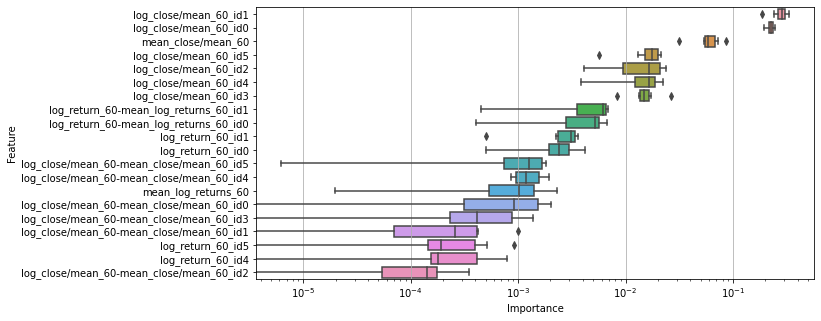

OOF corr score of BTCUSDT (ID=1) is 0.67131. (Weight: 1.00000)


Training model for ETHUSD           (ID=2 )
entering time series cross validation loop
doing split 1 out of 7
number of train data: 12306
number of val data:   2051
Training until validation scores don't improve for 50 rounds


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	tr's rmse: 0.00365247	tr's corr: 0.73062	vl's rmse: 0.00303214	vl's corr: 0.714378
[200]	tr's rmse: 0.00349754	tr's corr: 0.750639	vl's rmse: 0.00294649	vl's corr: 0.732739
[300]	tr's rmse: 0.00343959	tr's corr: 0.758848	vl's rmse: 0.00292108	vl's corr: 0.738551
[400]	tr's rmse: 0.00340979	tr's corr: 0.763186	vl's rmse: 0.0028994	vl's corr: 0.743299
[500]	tr's rmse: 0.00339258	tr's corr: 0.765641	vl's rmse: 0.00289156	vl's corr: 0.745013
[600]	tr's rmse: 0.00338273	tr's corr: 0.767002	vl's rmse: 0.00288606	vl's corr: 0.746279
[700]	tr's rmse: 0.00337421	tr's corr: 0.768244	vl's rmse: 0.00288202	vl's corr: 0.747155
Early stopping, best iteration is:
[740]	tr's rmse: 0.00337036	tr's corr: 0.768765	vl's rmse: 0.00287808	vl's corr: 0.747987
Evaluated only: rmse
Trained model was saved to 'trained_model_id2_fold0.pkl'

doing split 2 out of 7
number of train data: 12306
number of val data:   2051
Training until validation scores don't improve for 50 rounds


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	tr's rmse: 0.00362702	tr's corr: 0.72786	vl's rmse: 0.00314688	vl's corr: 0.752587
[200]	tr's rmse: 0.00345769	tr's corr: 0.750844	vl's rmse: 0.00304925	vl's corr: 0.766774
[300]	tr's rmse: 0.00340013	tr's corr: 0.758969	vl's rmse: 0.00302014	vl's corr: 0.771951
[400]	tr's rmse: 0.00337087	tr's corr: 0.763069	vl's rmse: 0.00300639	vl's corr: 0.774554
[500]	tr's rmse: 0.00335561	tr's corr: 0.765288	vl's rmse: 0.00299645	vl's corr: 0.776389
[600]	tr's rmse: 0.00334659	tr's corr: 0.766612	vl's rmse: 0.00299109	vl's corr: 0.777366
[700]	tr's rmse: 0.00333946	tr's corr: 0.767512	vl's rmse: 0.00298838	vl's corr: 0.777936
[800]	tr's rmse: 0.00333393	tr's corr: 0.768255	vl's rmse: 0.00298609	vl's corr: 0.778426
[900]	tr's rmse: 0.00332803	tr's corr: 0.769105	vl's rmse: 0.00298465	vl's corr: 0.778765
Early stopping, best iteration is:
[881]	tr's rmse: 0.00332912	tr's corr: 0.769004	vl's rmse: 0.00298406	vl's corr: 0.778807
Evaluated only: rmse
Trained model was saved to 'trained_model_id2

/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	tr's rmse: 0.0036648	tr's corr: 0.727176	vl's rmse: 0.00288968	vl's corr: 0.759222
[200]	tr's rmse: 0.00348612	tr's corr: 0.752066	vl's rmse: 0.00277476	vl's corr: 0.776405
[300]	tr's rmse: 0.00342716	tr's corr: 0.76013	vl's rmse: 0.00274697	vl's corr: 0.780501
[400]	tr's rmse: 0.00339801	tr's corr: 0.764227	vl's rmse: 0.00273696	vl's corr: 0.78188
[500]	tr's rmse: 0.00337936	tr's corr: 0.767073	vl's rmse: 0.00273023	vl's corr: 0.782991
Early stopping, best iteration is:
[532]	tr's rmse: 0.00337648	tr's corr: 0.767379	vl's rmse: 0.00272949	vl's corr: 0.783012
Evaluated only: rmse
Trained model was saved to 'trained_model_id2_fold2.pkl'

doing split 4 out of 7
number of train data: 12306
number of val data:   2051
Training until validation scores don't improve for 50 rounds


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	tr's rmse: 0.00352467	tr's corr: 0.727584	vl's rmse: 0.00392777	vl's corr: 0.72615
[200]	tr's rmse: 0.00337293	tr's corr: 0.748574	vl's rmse: 0.00378714	vl's corr: 0.742074
[300]	tr's rmse: 0.00330911	tr's corr: 0.758173	vl's rmse: 0.00373081	vl's corr: 0.749335
[400]	tr's rmse: 0.00327835	tr's corr: 0.76269	vl's rmse: 0.00370889	vl's corr: 0.751972
[500]	tr's rmse: 0.00325862	tr's corr: 0.765779	vl's rmse: 0.00369493	vl's corr: 0.753749
[600]	tr's rmse: 0.00324911	tr's corr: 0.76721	vl's rmse: 0.00368847	vl's corr: 0.754512
[700]	tr's rmse: 0.0032404	tr's corr: 0.768466	vl's rmse: 0.00368137	vl's corr: 0.755455
[800]	tr's rmse: 0.00323297	tr's corr: 0.76951	vl's rmse: 0.00367671	vl's corr: 0.75598
[900]	tr's rmse: 0.00322722	tr's corr: 0.77024	vl's rmse: 0.00367385	vl's corr: 0.756262
[1000]	tr's rmse: 0.00322304	tr's corr: 0.770904	vl's rmse: 0.00367081	vl's corr: 0.756683
[1100]	tr's rmse: 0.0032195	tr's corr: 0.771407	vl's rmse: 0.00366903	vl's corr: 0.756874
[1200]	tr's rmse

/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	tr's rmse: 0.00318449	tr's corr: 0.738815	vl's rmse: 0.00587829	vl's corr: 0.648981
[200]	tr's rmse: 0.00304698	tr's corr: 0.758771	vl's rmse: 0.00569925	vl's corr: 0.669118
[300]	tr's rmse: 0.00300034	tr's corr: 0.765977	vl's rmse: 0.00564254	vl's corr: 0.675161
[400]	tr's rmse: 0.00298169	tr's corr: 0.768623	vl's rmse: 0.0056166	vl's corr: 0.677713
[500]	tr's rmse: 0.0029691	tr's corr: 0.770667	vl's rmse: 0.0055997	vl's corr: 0.679884
[600]	tr's rmse: 0.00296129	tr's corr: 0.77184	vl's rmse: 0.00558938	vl's corr: 0.680867
[700]	tr's rmse: 0.00295727	tr's corr: 0.772483	vl's rmse: 0.0055843	vl's corr: 0.681389
[800]	tr's rmse: 0.00295244	tr's corr: 0.773202	vl's rmse: 0.00557942	vl's corr: 0.681765
[900]	tr's rmse: 0.00294896	tr's corr: 0.773717	vl's rmse: 0.00557356	vl's corr: 0.682368
[1000]	tr's rmse: 0.0029463	tr's corr: 0.774049	vl's rmse: 0.00557019	vl's corr: 0.682602
[1100]	tr's rmse: 0.00294367	tr's corr: 0.774442	vl's rmse: 0.0055674	vl's corr: 0.68283
[1200]	tr's rmse

/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	tr's rmse: 0.00366382	tr's corr: 0.736353	vl's rmse: 0.00279489	vl's corr: 0.731427
[200]	tr's rmse: 0.00348213	tr's corr: 0.760371	vl's rmse: 0.00272122	vl's corr: 0.742099
[300]	tr's rmse: 0.00341746	tr's corr: 0.768993	vl's rmse: 0.00270455	vl's corr: 0.742041
[400]	tr's rmse: 0.00338903	tr's corr: 0.772725	vl's rmse: 0.00270006	vl's corr: 0.740902
Early stopping, best iteration is:
[368]	tr's rmse: 0.00339686	tr's corr: 0.771593	vl's rmse: 0.00270003	vl's corr: 0.741337
Evaluated only: rmse
Trained model was saved to 'trained_model_id2_fold5.pkl'

doing split 7 out of 7
number of train data: 12306
number of val data:   2051
Training until validation scores don't improve for 50 rounds


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	tr's rmse: 0.00364185	tr's corr: 0.727165	vl's rmse: 0.00314645	vl's corr: 0.722081
[200]	tr's rmse: 0.00348297	tr's corr: 0.748877	vl's rmse: 0.00302357	vl's corr: 0.743417
[300]	tr's rmse: 0.00342078	tr's corr: 0.757799	vl's rmse: 0.00297452	vl's corr: 0.752424
[400]	tr's rmse: 0.00338878	tr's corr: 0.762545	vl's rmse: 0.00294578	vl's corr: 0.757791
[500]	tr's rmse: 0.00337268	tr's corr: 0.764689	vl's rmse: 0.0029353	vl's corr: 0.759653
[600]	tr's rmse: 0.00336349	tr's corr: 0.766085	vl's rmse: 0.00292614	vl's corr: 0.761311
[700]	tr's rmse: 0.00335643	tr's corr: 0.76712	vl's rmse: 0.00292156	vl's corr: 0.762188
[800]	tr's rmse: 0.00335073	tr's corr: 0.767893	vl's rmse: 0.00291865	vl's corr: 0.762703
[900]	tr's rmse: 0.00334661	tr's corr: 0.768378	vl's rmse: 0.00291716	vl's corr: 0.762953
[1000]	tr's rmse: 0.00334285	tr's corr: 0.768937	vl's rmse: 0.0029152	vl's corr: 0.763309
[1100]	tr's rmse: 0.00333984	tr's corr: 0.7693	vl's rmse: 0.00291409	vl's corr: 0.76351
[1200]	tr's rm

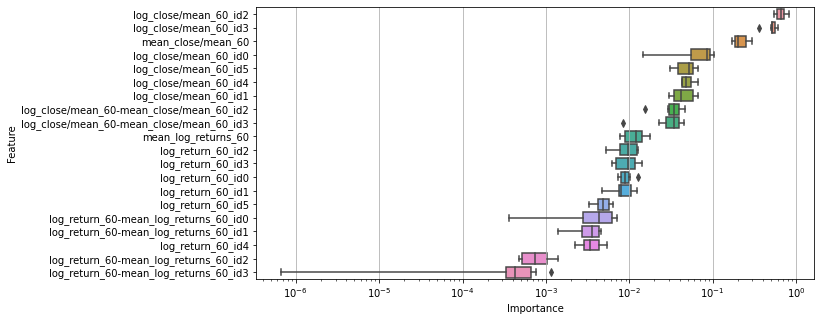

OOF corr score of ETHUSD (ID=2) is 0.73668. (Weight: 1.00000)


Training model for ETHUSDT          (ID=3 )
entering time series cross validation loop
doing split 1 out of 7
number of train data: 12330
number of val data:   2055
Training until validation scores don't improve for 50 rounds


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	tr's rmse: 0.00362623	tr's corr: 0.728018	vl's rmse: 0.00304789	vl's corr: 0.708285
[200]	tr's rmse: 0.00346265	tr's corr: 0.75004	vl's rmse: 0.00295034	vl's corr: 0.729358
[300]	tr's rmse: 0.00340513	tr's corr: 0.758226	vl's rmse: 0.00292727	vl's corr: 0.734855
[400]	tr's rmse: 0.00337971	tr's corr: 0.761914	vl's rmse: 0.00291591	vl's corr: 0.737501
[500]	tr's rmse: 0.00336061	tr's corr: 0.76473	vl's rmse: 0.0029148	vl's corr: 0.738034
Early stopping, best iteration is:
[481]	tr's rmse: 0.00336419	tr's corr: 0.764204	vl's rmse: 0.00291121	vl's corr: 0.738627
Evaluated only: rmse
Trained model was saved to 'trained_model_id3_fold0.pkl'

doing split 2 out of 7
number of train data: 12330
number of val data:   2055
Training until validation scores don't improve for 50 rounds


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	tr's rmse: 0.00359457	tr's corr: 0.727079	vl's rmse: 0.00314603	vl's corr: 0.74918
[200]	tr's rmse: 0.00343357	tr's corr: 0.748895	vl's rmse: 0.00305246	vl's corr: 0.763002
[300]	tr's rmse: 0.00337368	tr's corr: 0.757647	vl's rmse: 0.00301969	vl's corr: 0.768892
[400]	tr's rmse: 0.00334146	tr's corr: 0.762202	vl's rmse: 0.00300778	vl's corr: 0.771224
[500]	tr's rmse: 0.00332807	tr's corr: 0.763921	vl's rmse: 0.00300348	vl's corr: 0.772153
[600]	tr's rmse: 0.00331766	tr's corr: 0.765376	vl's rmse: 0.00299795	vl's corr: 0.773249
[700]	tr's rmse: 0.00330981	tr's corr: 0.766493	vl's rmse: 0.00299378	vl's corr: 0.774099
[800]	tr's rmse: 0.0033051	tr's corr: 0.767181	vl's rmse: 0.00299123	vl's corr: 0.774599
[900]	tr's rmse: 0.00330013	tr's corr: 0.76793	vl's rmse: 0.00298785	vl's corr: 0.775241
[1000]	tr's rmse: 0.00329543	tr's corr: 0.768557	vl's rmse: 0.00298541	vl's corr: 0.775731
[1100]	tr's rmse: 0.00329229	tr's corr: 0.769007	vl's rmse: 0.00298462	vl's corr: 0.775927
[1200]	tr's

/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	tr's rmse: 0.00362933	tr's corr: 0.727033	vl's rmse: 0.00285069	vl's corr: 0.760513
[200]	tr's rmse: 0.00345549	tr's corr: 0.751661	vl's rmse: 0.00274554	vl's corr: 0.776491
[300]	tr's rmse: 0.00339344	tr's corr: 0.760341	vl's rmse: 0.00271735	vl's corr: 0.780672
[400]	tr's rmse: 0.00336449	tr's corr: 0.764219	vl's rmse: 0.00270787	vl's corr: 0.782017
[500]	tr's rmse: 0.00334715	tr's corr: 0.766673	vl's rmse: 0.00270011	vl's corr: 0.783333
[600]	tr's rmse: 0.00333647	tr's corr: 0.768108	vl's rmse: 0.00269607	vl's corr: 0.783922
[700]	tr's rmse: 0.00332704	tr's corr: 0.769503	vl's rmse: 0.00269221	vl's corr: 0.784581
[800]	tr's rmse: 0.00332209	tr's corr: 0.770243	vl's rmse: 0.00269022	vl's corr: 0.784933
[900]	tr's rmse: 0.00331535	tr's corr: 0.771254	vl's rmse: 0.00268588	vl's corr: 0.785737
[1000]	tr's rmse: 0.00331189	tr's corr: 0.771623	vl's rmse: 0.00268425	vl's corr: 0.785991
[1100]	tr's rmse: 0.00330778	tr's corr: 0.772192	vl's rmse: 0.00268275	vl's corr: 0.786201
[1200]	t

/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	tr's rmse: 0.00350766	tr's corr: 0.72442	vl's rmse: 0.00388014	vl's corr: 0.723687
[200]	tr's rmse: 0.0033447	tr's corr: 0.748307	vl's rmse: 0.00371746	vl's corr: 0.743991
[300]	tr's rmse: 0.00328651	tr's corr: 0.757022	vl's rmse: 0.00367006	vl's corr: 0.74989
[400]	tr's rmse: 0.00325675	tr's corr: 0.761367	vl's rmse: 0.00364803	vl's corr: 0.752523
[500]	tr's rmse: 0.00323797	tr's corr: 0.764216	vl's rmse: 0.00363685	vl's corr: 0.753883
[600]	tr's rmse: 0.00322576	tr's corr: 0.766079	vl's rmse: 0.00362834	vl's corr: 0.754984
[700]	tr's rmse: 0.00321826	tr's corr: 0.767192	vl's rmse: 0.00362247	vl's corr: 0.75574
[800]	tr's rmse: 0.0032111	tr's corr: 0.768395	vl's rmse: 0.00361793	vl's corr: 0.756431
[900]	tr's rmse: 0.00320578	tr's corr: 0.769243	vl's rmse: 0.00361414	vl's corr: 0.756894
[1000]	tr's rmse: 0.00320039	tr's corr: 0.769922	vl's rmse: 0.00361171	vl's corr: 0.757163
[1100]	tr's rmse: 0.00319718	tr's corr: 0.770359	vl's rmse: 0.00361003	vl's corr: 0.757357
[1200]	tr's r

/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	tr's rmse: 0.00315977	tr's corr: 0.737732	vl's rmse: 0.00579253	vl's corr: 0.652701
[200]	tr's rmse: 0.00302924	tr's corr: 0.756525	vl's rmse: 0.00562802	vl's corr: 0.66986
[300]	tr's rmse: 0.00298236	tr's corr: 0.764163	vl's rmse: 0.00556461	vl's corr: 0.677786
[400]	tr's rmse: 0.00296473	tr's corr: 0.766445	vl's rmse: 0.00553912	vl's corr: 0.679757
[500]	tr's rmse: 0.00295411	tr's corr: 0.768136	vl's rmse: 0.00552437	vl's corr: 0.681261
[600]	tr's rmse: 0.00294655	tr's corr: 0.769325	vl's rmse: 0.0055139	vl's corr: 0.682403
[700]	tr's rmse: 0.00293979	tr's corr: 0.770513	vl's rmse: 0.00550515	vl's corr: 0.683474
[800]	tr's rmse: 0.00293662	tr's corr: 0.770941	vl's rmse: 0.0054996	vl's corr: 0.684016
[900]	tr's rmse: 0.00293254	tr's corr: 0.771534	vl's rmse: 0.0054934	vl's corr: 0.684617
[1000]	tr's rmse: 0.00293015	tr's corr: 0.771916	vl's rmse: 0.00549005	vl's corr: 0.685
[1100]	tr's rmse: 0.00292806	tr's corr: 0.77216	vl's rmse: 0.00548741	vl's corr: 0.685072
[1200]	tr's rmse

/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	tr's rmse: 0.00364007	tr's corr: 0.733916	vl's rmse: 0.00273826	vl's corr: 0.736219
[200]	tr's rmse: 0.00345184	tr's corr: 0.759511	vl's rmse: 0.00266298	vl's corr: 0.745496
[300]	tr's rmse: 0.00338905	tr's corr: 0.768507	vl's rmse: 0.00265262	vl's corr: 0.745061
[400]	tr's rmse: 0.00335996	tr's corr: 0.7723	vl's rmse: 0.00264643	vl's corr: 0.744434
Early stopping, best iteration is:
[407]	tr's rmse: 0.00335851	tr's corr: 0.772386	vl's rmse: 0.00264555	vl's corr: 0.744321
Evaluated only: rmse
Trained model was saved to 'trained_model_id3_fold5.pkl'

doing split 7 out of 7
number of train data: 12330
number of val data:   2055


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.0035978	tr's corr: 0.728893	vl's rmse: 0.00312616	vl's corr: 0.721805
[200]	tr's rmse: 0.00344199	tr's corr: 0.749421	vl's rmse: 0.0030113	vl's corr: 0.741758
[300]	tr's rmse: 0.00339103	tr's corr: 0.75692	vl's rmse: 0.00296994	vl's corr: 0.749641
[400]	tr's rmse: 0.00336644	tr's corr: 0.760213	vl's rmse: 0.00295392	vl's corr: 0.752521
[500]	tr's rmse: 0.00335182	tr's corr: 0.762269	vl's rmse: 0.00294425	vl's corr: 0.754307
[600]	tr's rmse: 0.00334071	tr's corr: 0.763914	vl's rmse: 0.00293564	vl's corr: 0.75591
[700]	tr's rmse: 0.00333455	tr's corr: 0.764799	vl's rmse: 0.00293275	vl's corr: 0.756505
[800]	tr's rmse: 0.00332838	tr's corr: 0.765705	vl's rmse: 0.00292905	vl's corr: 0.757194
[900]	tr's rmse: 0.00332441	tr's corr: 0.766255	vl's rmse: 0.00292696	vl's corr: 0.757576
[1000]	tr's rmse: 0.00332056	tr's corr: 0.766746	vl's rmse: 0.00292429	vl's corr: 0.758109
[1100]	tr's rmse: 0.0033175	tr's corr: 0.7

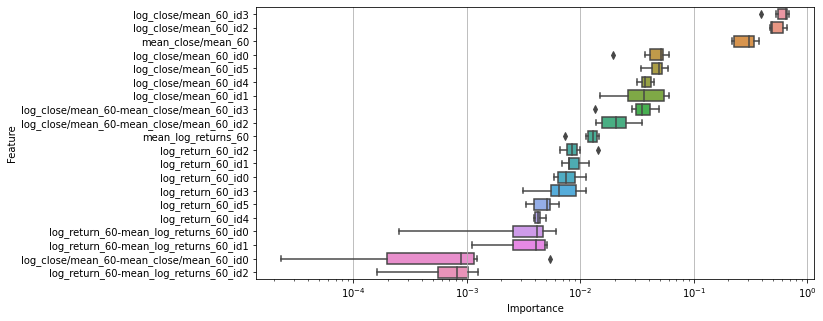

OOF corr score of ETHUSDT (ID=3) is 0.73614. (Weight: 1.00000)


Training model for XRPUSD           (ID=4 )
entering time series cross validation loop
doing split 1 out of 7
number of train data: 12181
number of val data:   2030
Training until validation scores don't improve for 50 rounds


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	tr's rmse: 0.00307912	tr's corr: 0.714916	vl's rmse: 0.00337501	vl's corr: 0.627489
[200]	tr's rmse: 0.00295962	tr's corr: 0.734654	vl's rmse: 0.00334496	vl's corr: 0.635898
[300]	tr's rmse: 0.00291113	tr's corr: 0.743724	vl's rmse: 0.00334205	vl's corr: 0.638186
Early stopping, best iteration is:
[258]	tr's rmse: 0.00292759	tr's corr: 0.740848	vl's rmse: 0.00334056	vl's corr: 0.637955
Evaluated only: rmse
Trained model was saved to 'trained_model_id4_fold0.pkl'

doing split 2 out of 7
number of train data: 12181
number of val data:   2030
Training until validation scores don't improve for 50 rounds


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	tr's rmse: 0.00311978	tr's corr: 0.703142	vl's rmse: 0.00313713	vl's corr: 0.708266
[200]	tr's rmse: 0.00300257	tr's corr: 0.723411	vl's rmse: 0.0030244	vl's corr: 0.727555
[300]	tr's rmse: 0.00296362	tr's corr: 0.730639	vl's rmse: 0.0029894	vl's corr: 0.73394
[400]	tr's rmse: 0.00294961	tr's corr: 0.73314	vl's rmse: 0.00297799	vl's corr: 0.736002
[500]	tr's rmse: 0.00294175	tr's corr: 0.734493	vl's rmse: 0.00296986	vl's corr: 0.737491
[600]	tr's rmse: 0.002935	tr's corr: 0.735705	vl's rmse: 0.00296275	vl's corr: 0.738831
[700]	tr's rmse: 0.00292843	tr's corr: 0.736964	vl's rmse: 0.00295814	vl's corr: 0.739673
[800]	tr's rmse: 0.0029229	tr's corr: 0.737802	vl's rmse: 0.00295367	vl's corr: 0.740397
[900]	tr's rmse: 0.00291957	tr's corr: 0.738563	vl's rmse: 0.00294965	vl's corr: 0.741249
[1000]	tr's rmse: 0.00291696	tr's corr: 0.739089	vl's rmse: 0.00294711	vl's corr: 0.741753
[1100]	tr's rmse: 0.00291554	tr's corr: 0.73937	vl's rmse: 0.00294562	vl's corr: 0.742059
[1200]	tr's rmse

/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	tr's rmse: 0.00312711	tr's corr: 0.706929	vl's rmse: 0.00301	vl's corr: 0.718103
[200]	tr's rmse: 0.00300361	tr's corr: 0.727772	vl's rmse: 0.00290611	vl's corr: 0.733867
[300]	tr's rmse: 0.00295559	tr's corr: 0.73673	vl's rmse: 0.00287639	vl's corr: 0.738636
[400]	tr's rmse: 0.00294064	tr's corr: 0.739318	vl's rmse: 0.00286572	vl's corr: 0.740276
[500]	tr's rmse: 0.00292977	tr's corr: 0.741545	vl's rmse: 0.00285852	vl's corr: 0.741831
[600]	tr's rmse: 0.00292011	tr's corr: 0.743152	vl's rmse: 0.00285237	vl's corr: 0.742668
[700]	tr's rmse: 0.00291375	tr's corr: 0.744334	vl's rmse: 0.00284911	vl's corr: 0.743296
[800]	tr's rmse: 0.00290754	tr's corr: 0.745409	vl's rmse: 0.00284531	vl's corr: 0.743919
[900]	tr's rmse: 0.00290463	tr's corr: 0.745942	vl's rmse: 0.00284345	vl's corr: 0.74421
[1000]	tr's rmse: 0.00290114	tr's corr: 0.746591	vl's rmse: 0.002841	vl's corr: 0.744692
[1100]	tr's rmse: 0.00289852	tr's corr: 0.747018	vl's rmse: 0.00283886	vl's corr: 0.744981
[1200]	tr's rms

/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	tr's rmse: 0.00309469	tr's corr: 0.702368	vl's rmse: 0.00323544	vl's corr: 0.728616
[200]	tr's rmse: 0.00298368	tr's corr: 0.720966	vl's rmse: 0.00310543	vl's corr: 0.74743
[300]	tr's rmse: 0.00294509	tr's corr: 0.728394	vl's rmse: 0.00305991	vl's corr: 0.754951
[400]	tr's rmse: 0.00293	tr's corr: 0.731252	vl's rmse: 0.0030426	vl's corr: 0.757796
[500]	tr's rmse: 0.00292051	tr's corr: 0.732925	vl's rmse: 0.00303082	vl's corr: 0.759605
[600]	tr's rmse: 0.00291534	tr's corr: 0.733878	vl's rmse: 0.00302481	vl's corr: 0.760582
[700]	tr's rmse: 0.00290916	tr's corr: 0.735073	vl's rmse: 0.00301786	vl's corr: 0.761716
[800]	tr's rmse: 0.00290376	tr's corr: 0.736055	vl's rmse: 0.00301218	vl's corr: 0.762606
[900]	tr's rmse: 0.00289826	tr's corr: 0.737106	vl's rmse: 0.00300673	vl's corr: 0.763495
[1000]	tr's rmse: 0.00289565	tr's corr: 0.737706	vl's rmse: 0.00300365	vl's corr: 0.764068
[1100]	tr's rmse: 0.00289261	tr's corr: 0.738365	vl's rmse: 0.00300038	vl's corr: 0.764651
[1200]	tr's r

/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	tr's rmse: 0.00292252	tr's corr: 0.708257	vl's rmse: 0.00436346	vl's corr: 0.658688
[200]	tr's rmse: 0.00281099	tr's corr: 0.72874	vl's rmse: 0.00422376	vl's corr: 0.676635
[300]	tr's rmse: 0.00276727	tr's corr: 0.737257	vl's rmse: 0.00417472	vl's corr: 0.683142
[400]	tr's rmse: 0.00275354	tr's corr: 0.739895	vl's rmse: 0.004163	vl's corr: 0.684456
[500]	tr's rmse: 0.00274424	tr's corr: 0.741599	vl's rmse: 0.00415367	vl's corr: 0.685476
[600]	tr's rmse: 0.00273673	tr's corr: 0.743159	vl's rmse: 0.00414687	vl's corr: 0.686457
[700]	tr's rmse: 0.00273122	tr's corr: 0.7442	vl's rmse: 0.0041396	vl's corr: 0.687581
[800]	tr's rmse: 0.00272611	tr's corr: 0.745105	vl's rmse: 0.00413401	vl's corr: 0.688186
[900]	tr's rmse: 0.00272413	tr's corr: 0.745522	vl's rmse: 0.00413177	vl's corr: 0.688504
[1000]	tr's rmse: 0.00272076	tr's corr: 0.746224	vl's rmse: 0.00412832	vl's corr: 0.689013
[1100]	tr's rmse: 0.002719	tr's corr: 0.746472	vl's rmse: 0.00412715	vl's corr: 0.688989
[1200]	tr's rmse

/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	tr's rmse: 0.00324114	tr's corr: 0.712669	vl's rmse: 0.00194823	vl's corr: 0.728393
[200]	tr's rmse: 0.00311173	tr's corr: 0.733263	vl's rmse: 0.00188621	vl's corr: 0.745332
[300]	tr's rmse: 0.00306292	tr's corr: 0.742042	vl's rmse: 0.00187115	vl's corr: 0.748626
[400]	tr's rmse: 0.003042	tr's corr: 0.745624	vl's rmse: 0.00186669	vl's corr: 0.749258
[500]	tr's rmse: 0.00303164	tr's corr: 0.747361	vl's rmse: 0.00186435	vl's corr: 0.749223
Early stopping, best iteration is:
[511]	tr's rmse: 0.00303059	tr's corr: 0.747525	vl's rmse: 0.00186418	vl's corr: 0.749271
Evaluated only: rmse
Trained model was saved to 'trained_model_id4_fold5.pkl'

doing split 7 out of 7
number of train data: 12180
number of val data:   2031
Training until validation scores don't improve for 50 rounds


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	tr's rmse: 0.00317493	tr's corr: 0.707893	vl's rmse: 0.00267261	vl's corr: 0.699385
[200]	tr's rmse: 0.00304882	tr's corr: 0.728332	vl's rmse: 0.00254714	vl's corr: 0.728449
[300]	tr's rmse: 0.00301273	tr's corr: 0.734773	vl's rmse: 0.00251577	vl's corr: 0.735757
[400]	tr's rmse: 0.00299681	tr's corr: 0.737666	vl's rmse: 0.00250573	vl's corr: 0.738022
[500]	tr's rmse: 0.0029884	tr's corr: 0.739369	vl's rmse: 0.00249813	vl's corr: 0.739793
[600]	tr's rmse: 0.00298099	tr's corr: 0.740639	vl's rmse: 0.00249205	vl's corr: 0.741104
[700]	tr's rmse: 0.0029753	tr's corr: 0.7417	vl's rmse: 0.00248675	vl's corr: 0.74232
[800]	tr's rmse: 0.00296932	tr's corr: 0.742844	vl's rmse: 0.00248109	vl's corr: 0.743663
[900]	tr's rmse: 0.00296611	tr's corr: 0.743449	vl's rmse: 0.00247912	vl's corr: 0.744125
[1000]	tr's rmse: 0.00296297	tr's corr: 0.744019	vl's rmse: 0.00247846	vl's corr: 0.744285
Early stopping, best iteration is:
[952]	tr's rmse: 0.00296373	tr's corr: 0.743953	vl's rmse: 0.00247821

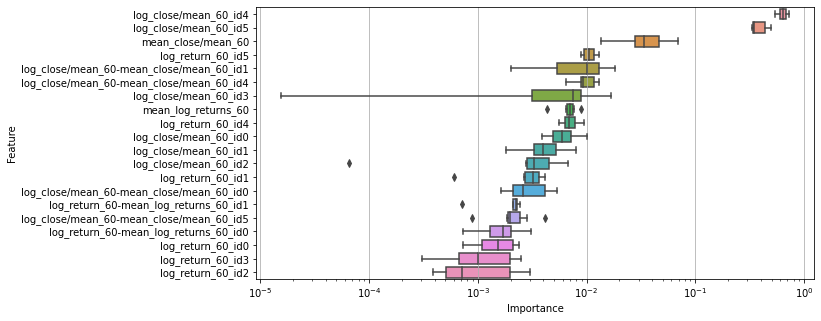

OOF corr score of XRPUSD (ID=4) is 0.72224. (Weight: 1.00000)


Training model for XRPUSDT          (ID=5 )
entering time series cross validation loop
doing split 1 out of 7
number of train data: 12239
number of val data:   2039
Training until validation scores don't improve for 50 rounds


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	tr's rmse: 0.00307226	tr's corr: 0.720622	vl's rmse: 0.00338905	vl's corr: 0.630141
[200]	tr's rmse: 0.00294636	tr's corr: 0.740775	vl's rmse: 0.00335942	vl's corr: 0.637959
Early stopping, best iteration is:
[244]	tr's rmse: 0.00292417	tr's corr: 0.744605	vl's rmse: 0.00335489	vl's corr: 0.639727
Evaluated only: rmse
Trained model was saved to 'trained_model_id5_fold0.pkl'

doing split 2 out of 7
number of train data: 12239
number of val data:   2039
Training until validation scores don't improve for 50 rounds


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	tr's rmse: 0.00311929	tr's corr: 0.707668	vl's rmse: 0.00311551	vl's corr: 0.718571
[200]	tr's rmse: 0.00300487	tr's corr: 0.726205	vl's rmse: 0.00301607	vl's corr: 0.733612
[300]	tr's rmse: 0.00296741	tr's corr: 0.732945	vl's rmse: 0.0029842	vl's corr: 0.739233
[400]	tr's rmse: 0.00295034	tr's corr: 0.736099	vl's rmse: 0.00297109	vl's corr: 0.741619
[500]	tr's rmse: 0.00294007	tr's corr: 0.738119	vl's rmse: 0.00296008	vl's corr: 0.743778
[600]	tr's rmse: 0.00293577	tr's corr: 0.738798	vl's rmse: 0.0029569	vl's corr: 0.744276
[700]	tr's rmse: 0.0029316	tr's corr: 0.739528	vl's rmse: 0.00295303	vl's corr: 0.744967
[800]	tr's rmse: 0.00292825	tr's corr: 0.740157	vl's rmse: 0.00294908	vl's corr: 0.7457
[900]	tr's rmse: 0.00292379	tr's corr: 0.741091	vl's rmse: 0.00294482	vl's corr: 0.74656
[1000]	tr's rmse: 0.00292053	tr's corr: 0.741659	vl's rmse: 0.00294086	vl's corr: 0.747305
[1100]	tr's rmse: 0.00291772	tr's corr: 0.742132	vl's rmse: 0.00293874	vl's corr: 0.747659
[1200]	tr's rm

/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	tr's rmse: 0.00312693	tr's corr: 0.710395	vl's rmse: 0.00300872	vl's corr: 0.726891
[200]	tr's rmse: 0.00299972	tr's corr: 0.731547	vl's rmse: 0.00290494	vl's corr: 0.741384
[300]	tr's rmse: 0.00295873	tr's corr: 0.738692	vl's rmse: 0.0028747	vl's corr: 0.746066
[400]	tr's rmse: 0.00294474	tr's corr: 0.741039	vl's rmse: 0.00286537	vl's corr: 0.747347
[500]	tr's rmse: 0.00293574	tr's corr: 0.742689	vl's rmse: 0.00286028	vl's corr: 0.748153
[600]	tr's rmse: 0.00293006	tr's corr: 0.743637	vl's rmse: 0.00285679	vl's corr: 0.748569
[700]	tr's rmse: 0.0029258	tr's corr: 0.744448	vl's rmse: 0.00285371	vl's corr: 0.749194
[800]	tr's rmse: 0.00292052	tr's corr: 0.74537	vl's rmse: 0.00284955	vl's corr: 0.749868
[900]	tr's rmse: 0.00291656	tr's corr: 0.746111	vl's rmse: 0.00284747	vl's corr: 0.750168
[1000]	tr's rmse: 0.00291308	tr's corr: 0.746763	vl's rmse: 0.0028456	vl's corr: 0.750463
[1100]	tr's rmse: 0.00291089	tr's corr: 0.747157	vl's rmse: 0.00284436	vl's corr: 0.750613
[1200]	tr's 

/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	tr's rmse: 0.00310065	tr's corr: 0.703545	vl's rmse: 0.00328195	vl's corr: 0.72673
[200]	tr's rmse: 0.00299248	tr's corr: 0.721177	vl's rmse: 0.00316212	vl's corr: 0.743547
[300]	tr's rmse: 0.00295415	tr's corr: 0.728337	vl's rmse: 0.00311798	vl's corr: 0.750646
[400]	tr's rmse: 0.00293661	tr's corr: 0.731772	vl's rmse: 0.00309624	vl's corr: 0.754359
[500]	tr's rmse: 0.00292812	tr's corr: 0.733395	vl's rmse: 0.00308632	vl's corr: 0.755978
[600]	tr's rmse: 0.0029201	tr's corr: 0.735092	vl's rmse: 0.00307739	vl's corr: 0.757554
[700]	tr's rmse: 0.00291577	tr's corr: 0.735876	vl's rmse: 0.00307254	vl's corr: 0.758305
[800]	tr's rmse: 0.00291114	tr's corr: 0.736674	vl's rmse: 0.00306759	vl's corr: 0.759031
[900]	tr's rmse: 0.0029085	tr's corr: 0.737212	vl's rmse: 0.00306426	vl's corr: 0.759599
[1000]	tr's rmse: 0.00290541	tr's corr: 0.737829	vl's rmse: 0.0030605	vl's corr: 0.760237
[1100]	tr's rmse: 0.00290267	tr's corr: 0.738403	vl's rmse: 0.00305755	vl's corr: 0.760775
[1200]	tr's 

/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	tr's rmse: 0.00291245	tr's corr: 0.714242	vl's rmse: 0.00434174	vl's corr: 0.672533
[200]	tr's rmse: 0.00281099	tr's corr: 0.731457	vl's rmse: 0.00423181	vl's corr: 0.68303
[300]	tr's rmse: 0.00277163	tr's corr: 0.738908	vl's rmse: 0.00418699	vl's corr: 0.68855
[400]	tr's rmse: 0.00275492	tr's corr: 0.742181	vl's rmse: 0.00417025	vl's corr: 0.690695
[500]	tr's rmse: 0.00274538	tr's corr: 0.743916	vl's rmse: 0.00415834	vl's corr: 0.692268
[600]	tr's rmse: 0.00274065	tr's corr: 0.744867	vl's rmse: 0.00415424	vl's corr: 0.692792
[700]	tr's rmse: 0.0027354	tr's corr: 0.746019	vl's rmse: 0.00414937	vl's corr: 0.693545
[800]	tr's rmse: 0.00273122	tr's corr: 0.746781	vl's rmse: 0.00414515	vl's corr: 0.693983
[900]	tr's rmse: 0.00272878	tr's corr: 0.747146	vl's rmse: 0.00414307	vl's corr: 0.694104
[1000]	tr's rmse: 0.00272675	tr's corr: 0.747398	vl's rmse: 0.00414111	vl's corr: 0.694163
[1100]	tr's rmse: 0.00272488	tr's corr: 0.747671	vl's rmse: 0.0041394	vl's corr: 0.694263
[1200]	tr's 

/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	tr's rmse: 0.0032467	tr's corr: 0.717276	vl's rmse: 0.00186045	vl's corr: 0.707972
[200]	tr's rmse: 0.00311217	tr's corr: 0.738971	vl's rmse: 0.00180812	vl's corr: 0.724853
[300]	tr's rmse: 0.00306945	tr's corr: 0.745901	vl's rmse: 0.0017957	vl's corr: 0.727871
[400]	tr's rmse: 0.00305058	tr's corr: 0.749109	vl's rmse: 0.00179153	vl's corr: 0.72867
[500]	tr's rmse: 0.00303689	tr's corr: 0.751522	vl's rmse: 0.00179012	vl's corr: 0.728822
Early stopping, best iteration is:
[470]	tr's rmse: 0.00304136	tr's corr: 0.750632	vl's rmse: 0.00178963	vl's corr: 0.728965
Evaluated only: rmse
Trained model was saved to 'trained_model_id5_fold5.pkl'

doing split 7 out of 7
number of train data: 12234
number of val data:   2044
Training until validation scores don't improve for 50 rounds


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	tr's rmse: 0.00317041	tr's corr: 0.712577	vl's rmse: 0.00264863	vl's corr: 0.712266
[200]	tr's rmse: 0.00305496	tr's corr: 0.730455	vl's rmse: 0.00254673	vl's corr: 0.733647
[300]	tr's rmse: 0.00301695	tr's corr: 0.737169	vl's rmse: 0.00251179	vl's corr: 0.741497
[400]	tr's rmse: 0.00299977	tr's corr: 0.740101	vl's rmse: 0.00249583	vl's corr: 0.744999
[500]	tr's rmse: 0.0029889	tr's corr: 0.742115	vl's rmse: 0.00249029	vl's corr: 0.746135
[600]	tr's rmse: 0.00298143	tr's corr: 0.743689	vl's rmse: 0.00248552	vl's corr: 0.74725
[700]	tr's rmse: 0.00297564	tr's corr: 0.744781	vl's rmse: 0.00248019	vl's corr: 0.74844
[800]	tr's rmse: 0.0029706	tr's corr: 0.745575	vl's rmse: 0.0024762	vl's corr: 0.749291
[900]	tr's rmse: 0.00296671	tr's corr: 0.746347	vl's rmse: 0.00247219	vl's corr: 0.750166
[1000]	tr's rmse: 0.00296371	tr's corr: 0.74693	vl's rmse: 0.00247042	vl's corr: 0.75058
[1100]	tr's rmse: 0.00295971	tr's corr: 0.747707	vl's rmse: 0.00246898	vl's corr: 0.750856
[1200]	tr's rms

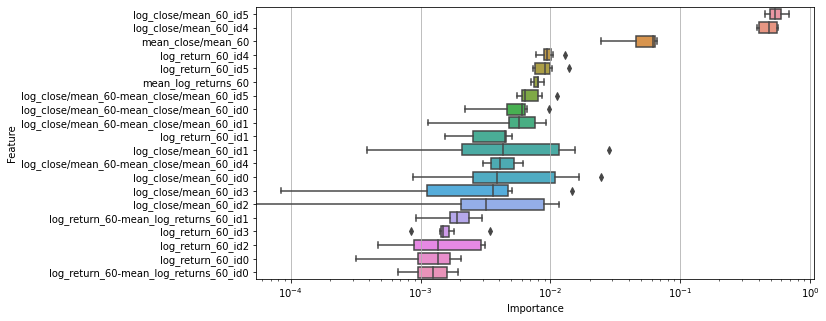

OOF corr score of XRPUSDT (ID=5) is 0.72408. (Weight: 1.00000)




In [157]:
oof = [ [] for id in range(NUM_OF_ASSETS)   ]

all_oof_pred = []
all_oof_valid = []
all_oof_weight = []

for asset_id, asset_name in zip(df_asset_details['Asset_ID'], df_asset_details['Asset_Name']):
    print(f"Training model for {asset_name:<16} (ID={asset_id:<2})")
    
    oof_pred, oof_valid = get_Xy_and_model_for_asset(feat, asset_id)
    
    weight_temp = float( df_asset_details.loc[  df_asset_details['Asset_ID'] == asset_id  , 'Weight'   ]  )
    
    all_oof_pred += oof_pred
    all_oof_valid += oof_valid
    all_oof_weight += [weight_temp] * len(oof_pred)
    
    oof[asset_id] = corr_score(     np.array(oof_pred)   ,    np.array(oof_valid)    )
    
    print(f'OOF corr score of {asset_name} (ID={asset_id}) is {oof[asset_id]:.5f}. (Weight: {float(weight_temp):.5f})')
    print('')
    print('')

In [ ]:
woof = 0
for id in range(NUM_OF_ASSETS):
    woof += oof[id] * float(  df_asset_details.loc[  df_asset_details['Asset_ID'] == id  , 'Weight'   ] )
woof = woof / df_asset_details['Weight'].sum()

print(f'OOF corr scores are;')
for oof_score in oof:
    print(f'      {oof_score:.5f}')
print(f'  simple average corr score: {np.mean(oof):.5f}.')
print(f'weighted average corr score: {woof:.5f}.')
print(f'')

all_oof_wcorr = wcorr_score(     np.array(all_oof_pred),    np.array(all_oof_valid),  np.array(all_oof_weight)   )
print(f'        weighted corr score: {all_oof_wcorr:.5f}.')

In [33]:
lr = log_return(df['Close_1'], 10)

In [34]:
lr


timestamp
2022-06-24 00:00:00+00:00         NaN
2022-06-24 00:01:00+00:00         NaN
2022-06-24 00:02:00+00:00         NaN
2022-06-24 00:03:00+00:00         NaN
2022-06-24 00:04:00+00:00         NaN
                               ...   
2022-07-03 23:55:00+00:00   -0.000052
2022-07-03 23:56:00+00:00   -0.000104
2022-07-03 23:57:00+00:00    0.000804
2022-07-03 23:58:00+00:00    0.000311
2022-07-03 23:59:00+00:00    0.000467
Name: Close_1, Length: 14398, dtype: float64

In [126]:
plt.figure(figsize=(8,4))
plt.plot(lr)
plt.show()

NameError: name 'lr' is not defined

<Figure size 576x288 with 0 Axes>

In [37]:
id = 1

lag = 10

df[f'log_close/mean_{lag}_id{id}'] = np.log( np.array(df[f'Close_{id}']) /  np.roll(np.append(np.convolve( np.array(df[f'Close_{id}']), np.ones(lag)/lag, mode="valid"), np.ones(lag-1)), lag-1)  )



df
 

,open,high,low,close,volume,Close_1,log_close/mean_10_id1
timestamp,,,,,,,
2022-06-24 00:00:00+00:00,21080.0,21102.0,21067.0,21096.5,2055830.0,21096.5,9.956862
2022-06-24 00:01:00+00:00,21101.0,21101.0,21052.0,21055.5,831328.0,21055.5,9.954917
2022-06-24 00:02:00+00:00,21057.5,21124.0,21050.0,21121.5,2318965.0,21121.5,9.958047
2022-06-24 00:03:00+00:00,21122.0,21140.0,21041.5,21042.0,2363491.0,21042.0,9.954276
2022-06-24 00:04:00+00:00,21043.0,21090.5,21028.0,21090.5,1187152.0,21090.5,9.956578
...,...,...,...,...,...,...,...
2022-07-03 23:55:00+00:00,19273.5,19277.5,19266.5,19277.0,262368.0,19277.0,0.000272
2022-07-03 23:56:00+00:00,19277.5,19277.5,19263.0,19263.0,167855.0,19263.0,-0.000444
2022-07-03 23:57:00+00:00,19263.5,19285.0,19262.5,19280.0,171432.0,19280.0,0.000358


In [39]:
df[f'log_return_{lag}_id{id}']     = np.log( np.array(df[f'Close_{id}']) /  np.roll(np.array(df[f'Close_{id}']), lag)  )
df

,open,high,low,close,volume,Close_1,log_close/mean_10_id1,log_return_10_id1
timestamp,,,,,,,,
2022-06-24 00:00:00+00:00,21080.0,21102.0,21067.0,21096.5,2055830.0,21096.5,9.956862,0.090169
2022-06-24 00:01:00+00:00,21101.0,21101.0,21052.0,21055.5,831328.0,21055.5,9.954917,0.088483
2022-06-24 00:02:00+00:00,21057.5,21124.0,21050.0,21121.5,2318965.0,21121.5,9.958047,0.091612
2022-06-24 00:03:00+00:00,21122.0,21140.0,21041.5,21042.0,2363491.0,21042.0,9.954276,0.087841
2022-06-24 00:04:00+00:00,21043.0,21090.5,21028.0,21090.5,1187152.0,21090.5,9.956578,0.089988
...,...,...,...,...,...,...,...,...
2022-07-03 23:55:00+00:00,19273.5,19277.5,19266.5,19277.0,262368.0,19277.0,0.000272,-0.000052
2022-07-03 23:56:00+00:00,19277.5,19277.5,19263.0,19263.0,167855.0,19263.0,-0.000444,-0.000104
2022-07-03 23:57:00+00:00,19263.5,19285.0,19262.5,19280.0,171432.0,19280.0,0.000358,0.000804


In [ ]:
def get_features(df, train=True):   
    if train == True:
        totimestamp = lambda s: np.int32(time.mktime(datetime.datetime.strptime(s, "%d/%m/%Y").timetuple()))
        valid_window = [totimestamp("12/03/2021")]
#         valid_window = [totimestamp("15/08/2021")]  #検証用
        df['train_flg'] = np.where(df['timestamp']>=valid_window[0], 0,1)

        supple_start_window = [totimestamp("22/09/2021")]
        if use_supple_for_train:
            df['train_flg'] = np.where(df['timestamp']>=supple_start_window[0], 1 ,df['train_flg']  )

   
    for id in range(14):    
        for lag in lags:
            df[f'log_close/mean_{lag}_id{id}'] = np.log( np.array(df[f'Close_{id}']) /  np.roll(np.append(np.convolve( np.array(df[f'Close_{id}']), np.ones(lag)/lag, mode="valid"), np.ones(lag-1)), lag-1)  )
            df[f'log_return_{lag}_id{id}']     = np.log( np.array(df[f'Close_{id}']) /  np.roll(np.array(df[f'Close_{id}']), lag)  )
    for lag in lags:
        df[f'mean_close/mean_{lag}'] =  np.mean(df.iloc[:,df.columns.str.startswith(f'log_close/mean_{lag}_id')], axis=1)
        df[f'mean_log_returns_{lag}'] = np.mean(df.iloc[:,df.columns.str.startswith(f'log_return_{lag}_id')] ,    axis=1)
        for id in range(14):
            df[f'log_close/mean_{lag}-mean_close/mean_{lag}_id{id}'] = np.array( df[f'log_close/mean_{lag}_id{id}']) - np.array( df[f'mean_close/mean_{lag}']  )
            df[f'log_return_{lag}-mean_log_returns_{lag}_id{id}']    = np.array( df[f'log_return_{lag}_id{id}'])     - np.array( df[f'mean_log_returns_{lag}'] )

    if train == True:
        for id in range(14):
            df = df.drop([f'Close_{id}'], axis=1)
        oldest_use_window = [totimestamp("12/01/2019")]
        df = df[  df['timestamp'] >= oldest_use_window[0]   ]

    return df